# Transport Network Damage Simulation 

## 0 Setup environment

In [1]:
import os
from glob import glob

import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import osmnx as ox
import pandas as pd
import seaborn as sns
from dask import compute, delayed
from dask.distributed import Client, progress

In [2]:
BASE_PATH = "data"
TRANSPORT_NETWORK_FILE = os.path.join(BASE_PATH, "merged_network_weighted.graphml")
CENTRALITY_FILE = os.path.join(BASE_PATH, "centrality_measures.csv")
TRAVEL_TIMES_FILE = os.path.join(BASE_PATH, "travel_times.csv")
SWATHS_DIR = os.path.join(BASE_PATH, "storm_swaths")

In [3]:
DAMAGE_INCREMENTS = np.arange(0, 50.1, 1)
ATTACK_STRATEGIES = ["degree", "betweenness", "closeness", "random"]
DISCONNECTED_TIME = 9999 * 60

In [ ]:
client = Client()
print("Dask Client ready. Dashboard at:", client.dashboard_link)

## 1 Load simulation data

In [5]:
# Load the main transport graph
graph_transport = ox.load_graphml(TRANSPORT_NETWORK_FILE)
for _, _, data in graph_transport.edges(data=True):
    data["segment_time"] = float(data["segment_time"])
gdf_nodes = ox.graph_to_gdfs(graph_transport, edges=False)

# Load supplementary data
df_centrality = pd.read_csv(CENTRALITY_FILE).set_index("osmid")
df_travel_times = pd.read_csv(TRAVEL_TIMES_FILE)

# Load and sample storm swaths
swath_files = glob(os.path.join(SWATHS_DIR, "*.gpkg"))
gdf_swaths = pd.concat([gpd.read_file(f) for f in swath_files], ignore_index=True)
gdf_swaths = gdf_swaths.sample(min(len(gdf_swaths), 16), random_state=42)

# Pre-calculate baseline values
Bi = df_travel_times["travel_time"].values
N = len(df_travel_times)
origin_node = df_travel_times["origin_node"].iloc[0]
destination_nodes = df_travel_times["destination_node"].tolist()

print(f"Loaded graph with {graph_transport.number_of_nodes()} nodes and {graph_transport.number_of_edges()} edges.")
print(f"Will run simulation on {len(gdf_swaths)} storm swaths.")

Loaded graph with 56932 nodes and 71895 edges.
Will run simulation on 16 storm swaths.


In [6]:
graph_future = client.scatter(graph_transport, broadcast=True)
nodes_future = client.scatter(gdf_nodes, broadcast=True)
centrality_future = client.scatter(df_centrality, broadcast=True)
Bi_future = client.scatter(Bi, broadcast=True)
destinations_future = client.scatter(destination_nodes, broadcast=True)

## 2 Define helper functions

In [7]:
def calculate_efficiency(Si, Bi, N):
    """Calculates relief delivery efficiency based on the paper's formula."""
    Si, Bi = np.array(Si), np.array(Bi)

    with np.errstate(divide="ignore", invalid="ignore"):
        ratio = Bi / Si

    log_term = np.log2(1 + ratio)

    return np.sum(log_term) / N


def run_damage_simulation(graph, nodes_to_remove, origin, destinations):
    """Recalculates travel times after removing nodes from a graph."""
    all_nodes = set(graph.nodes())
    nodes_to_keep = list(all_nodes - set(nodes_to_remove))
    graph_damaged = graph.subgraph(nodes_to_keep).copy()

    try:
        new_times = nx.single_source_dijkstra_path_length(graph_damaged, source=origin, weight="segment_time")
    except nx.NodeNotFound:
        return [DISCONNECTED_TIME] * len(destinations)

    return [new_times.get(dest, DISCONNECTED_TIME) for dest in destinations]


def run_single_simulation_case(
    storm_row,
    strategy,
    damage_pct,
    graph,
    gdf_nodes,
    df_centrality,
    Bi,
    N,
    origin,
    destinations,
):
    """Wrapper function to run a single simulation scenario."""
    storm_id = storm_row["SID"]
    gdf_swath = gpd.GeoDataFrame(geometry=[storm_row["geometry"]], crs=gdf_nodes.crs)

    candidate_nodes = gpd.sjoin(gdf_nodes, gdf_swath, how="inner", predicate="within").index.tolist()
    if not candidate_nodes:
        return None

    total_candidate_nodes = len(candidate_nodes)
    df_centrality_candidates = df_centrality.loc[candidate_nodes]

    if strategy == "random":
        ranked_nodes = list(np.random.permutation(candidate_nodes))
    else:
        ranked_nodes = df_centrality_candidates[strategy].sort_values(ascending=False).index.tolist()

    num_nodes_to_remove = int((damage_pct / 100) * total_candidate_nodes)
    nodes_to_remove = ranked_nodes[:num_nodes_to_remove]

    Si = run_damage_simulation(graph, nodes_to_remove, origin, destinations)
    efficiency = calculate_efficiency(Si, Bi, N)

    return {
        "storm_id": storm_id,
        "attack_strategy": strategy,
        "damage_percentage": damage_pct,
        "efficiency": efficiency,
    }

## 3 Run simulation

In [8]:
lazy_results = []

for _, storm_row in gdf_swaths.iterrows():
    for strategy in ATTACK_STRATEGIES:
        for D in DAMAGE_INCREMENTS:
            lazy_result = delayed(run_single_simulation_case)(
                storm_row,
                strategy,
                D,
                graph_future,
                nodes_future,
                centrality_future,
                Bi_future,
                N,
                origin_node,
                destinations_future,
            )
            lazy_results.append(lazy_result)

print(f"Created {len(lazy_results)} lazy tasks to be computed.")

Created 3264 lazy tasks to be computed.


In [9]:
print("Starting computation...")
results = compute(*lazy_results, progress=progress)
print("Computation finished.")

results = [r for r in results if r is not None]

df_results = pd.DataFrame(results)
df_results.to_csv(os.path.join(BASE_PATH, "damage_simulation_dask.csv"), index=False)

print(f"Results saved to damage_simulation_dask.csv")

Starting computation...
Computation finished.
Results saved to damage_simulation_dask.csv


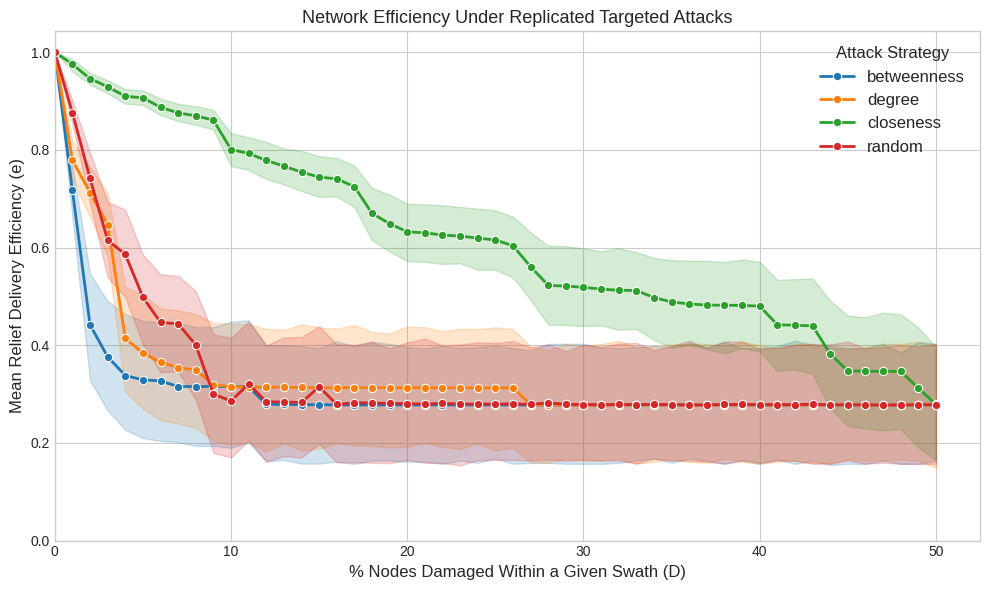

In [24]:
plt.style.use("seaborn-v0_8-whitegrid")
_, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(
    data=df_results,
    x="damage_percentage",
    y="efficiency",
    hue="attack_strategy",
    ax=ax,
    linewidth=2,
    hue_order=["betweenness", "degree", "closeness", "random"],
    errorbar=("ci", 75),
    marker="o",
)

ax.set_title("Network Efficiency Under Replicated Targeted Attacks", fontsize=13)
ax.set_xlabel("% Nodes Damaged Within a Given Swath (D)", fontsize=12)
ax.set_ylabel("Mean Relief Delivery Efficiency (e)", fontsize=12)
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
ax.legend(title="Attack Strategy", title_fontsize="12", fontsize="12")

plt.savefig(os.path.join(BASE_PATH, "damage_simulation_dask.png"), dpi=300)

plt.tight_layout()
plt.show()